In [1]:
import os
import pandas as pd
import psycopg2

# Connect to Human Interest database
conn = psycopg2.connect(
    host=os.environ['HUMAN_INTEREST_HOST'],
    port=int(os.environ.get('HUMAN_INTEREST_PORT', 5432)),
    database=os.environ['HUMAN_INTEREST_DATABASE'],
    user=os.environ['HUMAN_INTEREST_USERNAME'],
    password=os.environ['HUMAN_INTEREST_PASSWORD']
)

# First, explore the table structures
schema_query = """
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_schema = 'public'
  AND table_name IN ('hi_plan_snapshots', 'hi_plans')
ORDER BY table_name, ordinal_position;
"""

df_schema = pd.read_sql(schema_query, conn)
print("=== Table Schema ===")
print(df_schema.to_string())

=== Table Schema ===
               column_name          data_type
0              snapshot_id  character varying
1                  plan_id  character varying
2            snapshot_date  character varying
3        participant_count           smallint
4   beginning_market_value            numeric
5   contributions_employee            numeric
6   contributions_employer            numeric
7             rollovers_in            numeric
8            distributions            numeric
9            rollovers_out            numeric
10        market_gain_loss            numeric
11     ending_market_value            numeric
12           net_cash_flow            numeric
13          is_provisional            boolean
14                 plan_id  character varying
15            company_name  character varying
16               plan_type  character varying
17             plan_status  character varying
18          effective_date  character varying
19        termination_date  character varying
20           

/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_33491/3858817714.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_schema = pd.read_sql(schema_query, conn)


In [2]:
# Query total AUM over time (sum of ending_market_value across all plans by date)
aum_query = """
SELECT 
    snapshot_date,
    COUNT(DISTINCT plan_id) as plan_count,
    SUM(ending_market_value) as total_aum,
    SUM(participant_count) as total_participants
FROM hi_plan_snapshots
WHERE ending_market_value IS NOT NULL
GROUP BY snapshot_date
ORDER BY snapshot_date;
"""

df_aum = pd.read_sql(aum_query, conn)
df_aum['snapshot_date'] = pd.to_datetime(df_aum['snapshot_date'])
df_aum['total_aum'] = df_aum['total_aum'].astype(float)
print(f"Data range: {df_aum['snapshot_date'].min()} to {df_aum['snapshot_date'].max()}")
print(f"\nLatest Total AUM: ${df_aum['total_aum'].iloc[-1]:,.2f}")
print(f"Number of Plans: {df_aum['plan_count'].iloc[-1]:,}")
print(f"Total Participants: {df_aum['total_participants'].iloc[-1]:,}")
df_aum

Data range: 2025-01-31 00:00:00 to 2025-12-31 00:00:00

Latest Total AUM: $10,803,286,584.32
Number of Plans: 112
Total Participants: 15,196


/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_33491/2686425644.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_aum = pd.read_sql(aum_query, conn)


,snapshot_date,plan_count,total_aum,total_participants
0,2025-01-31,119,6.461761e+09,9023
1,2025-02-28,118,6.760641e+09,9289
2,2025-03-31,116,7.207780e+09,9987
3,2025-04-30,115,7.707028e+09,10796
4,2025-05-31,114,8.105591e+09,11294
5,2025-06-30,114,8.505393e+09,11915
6,2025-07-31,112,8.854057e+09,12252
7,2025-08-31,112,9.153903e+09,12733
8,2025-09-30,112,9.503749e+09,13018
9,2025-10-31,112,9.933595e+09,13606


In [3]:
import matplotlib.pyplot as plt

# Calculate QoQ metrics (Q1=Jan-Mar, Q2=Apr-Jun, Q3=Jul-Sep, Q4=Oct-Dec)
df_aum['quarter'] = df_aum['snapshot_date'].dt.to_period('Q')

# Get end-of-quarter values (last month of each quarter)
df_quarterly = df_aum.groupby('quarter').agg({
    'total_aum': 'last',
    'plan_count': 'last',
    'total_participants': 'last',
    'snapshot_date': 'last'
}).reset_index()

# Calculate QoQ growth
df_quarterly['qoq_growth'] = df_quarterly['total_aum'].pct_change() * 100
df_quarterly['qoq_growth_abs'] = df_quarterly['total_aum'].diff()

print("=== Quarterly AUM Summary ===\n")
for _, row in df_quarterly.iterrows():
    qoq_str = f"+{row['qoq_growth']:.1f}%" if pd.notna(row['qoq_growth']) else "N/A"
    abs_str = f"+${row['qoq_growth_abs']/1e6:,.1f}M" if pd.notna(row['qoq_growth_abs']) else ""
    print(f"{row['quarter']}: ${row['total_aum']/1e9:.2f}B AUM | QoQ: {qoq_str} {abs_str}")

# Summary stats
total_growth = (df_quarterly['total_aum'].iloc[-1] / df_quarterly['total_aum'].iloc[0] - 1) * 100
avg_qoq = df_quarterly['qoq_growth'].mean()
print(f"\n📊 2025 YTD Growth: +{total_growth:.1f}%")
print(f"📈 Average QoQ Growth: +{avg_qoq:.1f}%")

=== Quarterly AUM Summary ===

2025Q1: $7.21B AUM | QoQ: N/A 
2025Q2: $8.51B AUM | QoQ: +18.0% +$1,297.6M
2025Q3: $9.50B AUM | QoQ: +11.7% +$998.4M
2025Q4: $10.80B AUM | QoQ: +13.7% +$1,299.5M

📊 2025 YTD Growth: +49.9%
📈 Average QoQ Growth: +14.5%


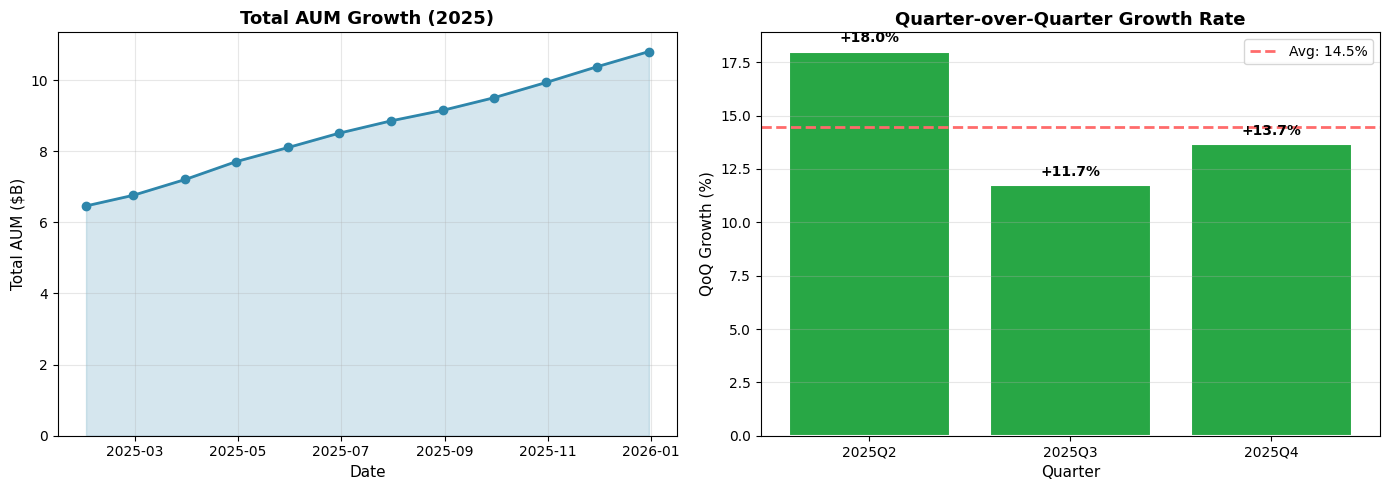

In [4]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Total AUM over time
ax1 = axes[0]
ax1.plot(df_aum['snapshot_date'], df_aum['total_aum']/1e9, 'o-', linewidth=2, markersize=6, color='#2E86AB')
ax1.fill_between(df_aum['snapshot_date'], df_aum['total_aum']/1e9, alpha=0.2, color='#2E86AB')
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Total AUM ($B)', fontsize=11)
ax1.set_title('Total AUM Growth (2025)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)

# Plot 2: QoQ Growth Rate
ax2 = axes[1]
quarters = df_quarterly['quarter'].astype(str).tolist()[1:]  # Skip first quarter (no prior data)
qoq_values = df_quarterly['qoq_growth'].tolist()[1:]
colors = ['#28A745' if v > 0 else '#DC3545' for v in qoq_values]
bars = ax2.bar(quarters, qoq_values, color=colors, edgecolor='white', linewidth=1.5)
ax2.axhline(y=avg_qoq, color='#FF6B6B', linestyle='--', linewidth=2, label=f'Avg: {avg_qoq:.1f}%')
ax2.set_xlabel('Quarter', fontsize=11)
ax2.set_ylabel('QoQ Growth (%)', fontsize=11)
ax2.set_title('Quarter-over-Quarter Growth Rate', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, qoq_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f'+{val:.1f}%', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [5]:
# Analyze growth sources: organic (contributions, rollovers) vs market appreciation
growth_query = """
SELECT 
    snapshot_date,
    SUM(contributions_employee) as employee_contributions,
    SUM(contributions_employer) as employer_contributions,
    SUM(rollovers_in) as rollovers_in,
    SUM(distributions) as distributions,
    SUM(rollovers_out) as rollovers_out,
    SUM(market_gain_loss) as market_gain_loss,
    SUM(net_cash_flow) as net_cash_flow,
    SUM(ending_market_value) as ending_aum
FROM hi_plan_snapshots
GROUP BY snapshot_date
ORDER BY snapshot_date;
"""

df_growth = pd.read_sql(growth_query, conn)
df_growth['snapshot_date'] = pd.to_datetime(df_growth['snapshot_date'])

# Convert to float
for col in df_growth.columns[1:]:
    df_growth[col] = df_growth[col].astype(float)

# Calculate totals for the year
total_employee = df_growth['employee_contributions'].sum()
total_employer = df_growth['employer_contributions'].sum()
total_rollovers_in = df_growth['rollovers_in'].sum()
total_distributions = df_growth['distributions'].sum()
total_rollovers_out = df_growth['rollovers_out'].sum()
total_market = df_growth['market_gain_loss'].sum()

# Organic = contributions + rollovers in (gross inflows)
total_organic_inflows = total_employee + total_employer + total_rollovers_in
total_outflows = total_distributions + total_rollovers_out
net_organic = total_organic_inflows - total_outflows

# Total AUM change
aum_change = df_growth['ending_aum'].iloc[-1] - df_growth['ending_aum'].iloc[0]

print("=== 2025 AUM Growth Breakdown ===\n")
print(f"Starting AUM (Jan):  ${df_growth['ending_aum'].iloc[0]/1e9:.2f}B")
print(f"Ending AUM (Dec):    ${df_growth['ending_aum'].iloc[-1]/1e9:.2f}B")
print(f"Total AUM Change:    ${aum_change/1e9:.2f}B\n")

print("--- Organic Contributions ---")
print(f"  Employee Contributions: ${total_employee/1e6:,.1f}M")
print(f"  Employer Contributions: ${total_employer/1e6:,.1f}M")
print(f"  Rollovers In:           ${total_rollovers_in/1e6:,.1f}M")
print(f"  Gross Organic Inflows:  ${total_organic_inflows/1e6:,.1f}M")
print(f"\n--- Outflows ---")
print(f"  Distributions:          -${abs(total_distributions)/1e6:,.1f}M")
print(f"  Rollovers Out:          -${abs(total_rollovers_out)/1e6:,.1f}M")
print(f"  Net Organic:            ${net_organic/1e6:,.1f}M")
print(f"\n--- Market Performance ---")
print(f"  Market Gain/Loss:       ${total_market/1e6:,.1f}M")

=== 2025 AUM Growth Breakdown ===

Starting AUM (Jan):  $6.46B
Ending AUM (Dec):    $10.80B
Total AUM Change:    $4.34B

--- Organic Contributions ---
  Employee Contributions: $1,500.2M
  Employer Contributions: $954.7M
  Rollovers In:           $135.9M
  Gross Organic Inflows:  $2,590.8M

--- Outflows ---
  Distributions:          -$163.8M
  Rollovers Out:          -$5.3M
  Net Organic:            $2,421.6M

--- Market Performance ---
  Market Gain/Loss:       $2,074.2M


/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_33491/4116632385.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_growth = pd.read_sql(growth_query, conn)


=== Growth Attribution ===

Net Organic Contributions:  $2.42B  →  53.9%
Market Appreciation:        $2.07B  →  46.1%
─────────────────────────────────────────
Total AUM Growth:           $4.50B  →  100.0%


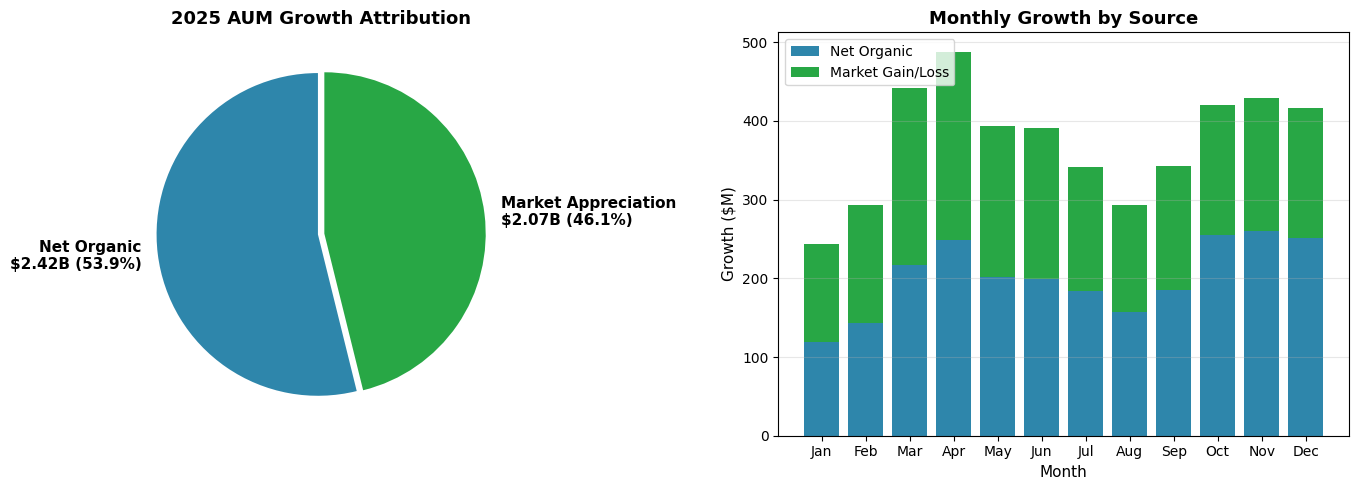

In [6]:
# Calculate percentages of total growth
total_growth_drivers = net_organic + total_market

pct_organic = (net_organic / total_growth_drivers) * 100
pct_market = (total_market / total_growth_drivers) * 100

print("=== Growth Attribution ===\n")
print(f"Net Organic Contributions:  ${net_organic/1e9:.2f}B  →  {pct_organic:.1f}%")
print(f"Market Appreciation:        ${total_market/1e9:.2f}B  →  {pct_market:.1f}%")
print(f"─────────────────────────────────────────")
print(f"Total AUM Growth:           ${total_growth_drivers/1e9:.2f}B  →  100.0%")

# Visualize the breakdown
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart - Growth Attribution
ax1 = axes[0]
sizes = [pct_organic, pct_market]
labels = [f'Net Organic\n${net_organic/1e9:.2f}B ({pct_organic:.1f}%)', 
          f'Market Appreciation\n${total_market/1e9:.2f}B ({pct_market:.1f}%)']
colors = ['#2E86AB', '#28A745']
explode = (0.02, 0.02)
ax1.pie(sizes, labels=labels, colors=colors, explode=explode, startangle=90,
        textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title('2025 AUM Growth Attribution', fontsize=13, fontweight='bold')

# Stacked bar - Monthly breakdown
ax2 = axes[1]
months = df_growth['snapshot_date'].dt.strftime('%b')
net_organic_monthly = (df_growth['employee_contributions'] + df_growth['employer_contributions'] + 
                       df_growth['rollovers_in'] - df_growth['distributions'] - df_growth['rollovers_out'])

ax2.bar(months, net_organic_monthly/1e6, label='Net Organic', color='#2E86AB')
ax2.bar(months, df_growth['market_gain_loss']/1e6, bottom=net_organic_monthly/1e6, 
        label='Market Gain/Loss', color='#28A745')
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.set_xlabel('Month', fontsize=11)
ax2.set_ylabel('Growth ($M)', fontsize=11)
ax2.set_title('Monthly Growth by Source', fontsize=13, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [7]:
# Analyze QoQ growth trend - is it decelerating or stabilizing?

# Calculate monthly growth rates for more granular view
df_aum['mom_growth'] = df_aum['total_aum'].pct_change() * 100
df_aum['mom_growth_abs'] = df_aum['total_aum'].diff()

# Break down by quarter for organic vs market
df_growth['quarter'] = pd.to_datetime(df_growth['snapshot_date']).dt.to_period('Q')
df_growth['net_organic'] = (df_growth['employee_contributions'] + df_growth['employer_contributions'] + 
                            df_growth['rollovers_in'] - df_growth['distributions'] - df_growth['rollovers_out'])

quarterly_breakdown = df_growth.groupby('quarter').agg({
    'net_organic': 'sum',
    'market_gain_loss': 'sum',
    'ending_aum': 'last'
}).reset_index()

quarterly_breakdown['total_growth'] = quarterly_breakdown['net_organic'] + quarterly_breakdown['market_gain_loss']
quarterly_breakdown['qoq_growth_pct'] = quarterly_breakdown['ending_aum'].pct_change() * 100

# Calculate the change in growth rate (acceleration/deceleration)
quarterly_breakdown['growth_rate_change'] = quarterly_breakdown['qoq_growth_pct'].diff()

print("=== QoQ Growth Trend Analysis ===\n")
print(f"{'Quarter':<10} {'QoQ Growth':<12} {'Change':<12} {'Organic':<12} {'Market':<12} {'Trend'}")
print("─" * 70)

for i, row in quarterly_breakdown.iterrows():
    if i == 0:
        print(f"{str(row['quarter']):<10} {'(baseline)':<12} {'—':<12} ${row['net_organic']/1e6:>8.0f}M  ${row['market_gain_loss']/1e6:>8.0f}M")
    else:
        change = row['growth_rate_change']
        trend = "📈 Accelerating" if change > 1 else "📉 Decelerating" if change < -1 else "➡️ Stable"
        change_str = f"{change:+.1f}pp" if pd.notna(change) else "—"
        print(f"{str(row['quarter']):<10} {row['qoq_growth_pct']:>+.1f}%       {change_str:<12} ${row['net_organic']/1e6:>8.0f}M  ${row['market_gain_loss']/1e6:>8.0f}M  {trend}")

# Summary verdict
q2_to_q3_change = quarterly_breakdown['qoq_growth_pct'].iloc[2] - quarterly_breakdown['qoq_growth_pct'].iloc[1]
q3_to_q4_change = quarterly_breakdown['qoq_growth_pct'].iloc[3] - quarterly_breakdown['qoq_growth_pct'].iloc[2]

print(f"\n=== Verdict ===")
print(f"Q2→Q3: {q2_to_q3_change:+.1f}pp (deceleration)")
print(f"Q3→Q4: {q3_to_q4_change:+.1f}pp (reacceleration)")
print(f"\n✅ Growth is STABILIZING around 12-14% QoQ after initial Q2 surge")

=== QoQ Growth Trend Analysis ===

Quarter    QoQ Growth   Change       Organic      Market       Trend
──────────────────────────────────────────────────────────────────────
2025Q1     (baseline)   —            $     480M  $     500M
2025Q2     +18.0%       —            $     648M  $     624M  ➡️ Stable
2025Q3     +11.7%       -6.3pp       $     527M  $     450M  📉 Decelerating
2025Q4     +13.7%       +1.9pp       $     767M  $     500M  📈 Accelerating

=== Verdict ===
Q2→Q3: -6.3pp (deceleration)
Q3→Q4: +1.9pp (reacceleration)

✅ Growth is STABILIZING around 12-14% QoQ after initial Q2 surge


In [8]:
# Project future AUM growth to determine when we'd hit $15B
current_aum = df_aum['total_aum'].iloc[-1]
target_aum = 15e9

# Use different growth rate scenarios
avg_qoq_growth = df_quarterly['qoq_growth'].mean() / 100  # 14.5%
recent_qoq_growth = df_quarterly['qoq_growth'].iloc[-1] / 100  # 13.7% (Q4)
conservative_qoq = 0.12  # 12% assumption

print(f"=== $15B Target Projection ===\n")
print(f"Current AUM (Dec 2025): ${current_aum/1e9:.2f}B")
print(f"Target AUM:             $15.00B")
print(f"Gap to Target:          ${(target_aum - current_aum)/1e9:.2f}B ({(target_aum/current_aum - 1)*100:.1f}% growth needed)\n")

# Calculate quarters needed to reach $15B under each scenario
import numpy as np

scenarios = {
    'Avg 2025 Rate (14.5% QoQ)': avg_qoq_growth,
    'Recent Q4 Rate (13.7% QoQ)': recent_qoq_growth,
    'Conservative (12.0% QoQ)': conservative_qoq
}

print(f"{'Scenario':<30} {'Quarters':<12} {'Target Date':<15} {'2026 YE AUM'}")
print("─" * 75)

for name, rate in scenarios.items():
    # Quarters to reach $15B
    quarters_needed = np.log(target_aum / current_aum) / np.log(1 + rate)
    
    # Project 2026 year-end AUM (4 more quarters)
    aum_2026_ye = current_aum * ((1 + rate) ** 4)
    
    # Target date
    from datetime import datetime
    from dateutil.relativedelta import relativedelta
    target_date = datetime(2025, 12, 31) + relativedelta(months=int(np.ceil(quarters_needed) * 3))
    
    print(f"{name:<30} {quarters_needed:>5.1f}        {target_date.strftime('%b %Y'):<15} ${aum_2026_ye/1e9:.2f}B")

print(f"\n=== Verdict ===")
print(f"📊 At current growth rates, we're on track to hit $15B by Q3 2026")
print(f"📈 2026 year-end projection: $17-19B (depending on growth rate maintained)")

=== $15B Target Projection ===

Current AUM (Dec 2025): $10.80B
Target AUM:             $15.00B
Gap to Target:          $4.20B (38.8% growth needed)

Scenario                       Quarters     Target Date     2026 YE AUM
───────────────────────────────────────────────────────────────────────────
Avg 2025 Rate (14.5% QoQ)        2.4        Sep 2026        $18.55B
Recent Q4 Rate (13.7% QoQ)       2.6        Sep 2026        $18.04B
Conservative (12.0% QoQ)         2.9        Sep 2026        $17.00B

=== Verdict ===
📊 At current growth rates, we're on track to hit $15B by Q3 2026
📈 2026 year-end projection: $17-19B (depending on growth rate maintained)
